In [1]:
import torch
import gpytorch
import botorch

import matplotlib.pyplot as plt

plt.style.use("bmh")

from tqdm.notebook import tqdm

## 4.1 Navigating the search space in Bayesian optimization

In [2]:
def forrester_1d(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1
    return y.squeeze(-1)


def visualize_gp_belief_and_policy(model, likelihood, policy=None, next_x=None):
    with torch.no_grad():
        predictive_distribution = likelihood(model(xs))
        predictive_mean = predictive_distribution.mean
        predictive_upper, predictive_lower = predictive_distribution.confidence_region()

        if policy is not None:
            acquisition_score = policy(xs.unsqueeze(1))

    if policy is None:
        plt.figure(figsize=(8, 3))

        plt.plot(xs, ys, label="objective", c="r")
        plt.scatter(train_x, train_y, marker="x", c="k", label="observations")

        plt.plot(xs, predictive_mean, label="mean")
        plt.fill_between(
            xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
        )

        plt.legend()
        plt.show()
    else:
        fig, ax = plt.subplots(
            2, 1, figsize=(8, 6), sharex=True, gridspec_kw={"height_ratios": [2, 1]}
        )

        # GP belief
        ax[0].plot(xs, ys, label="objective", c="r")
        ax[0].scatter(train_x, train_y, marker="x", c="k", label="observations")

        ax[0].plot(xs, predictive_mean, label="mean")
        ax[0].fill_between(
            xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
        )

        if next_x is not None:
            ax[0].axvline(next_x.item(), linestyle="dotted", c="k")

        ax[0].legend()
        ax[0].set_ylabel("predictive")

        # acquisition score
        ax[1].plot(xs, acquisition_score, c="g")
        ax[1].fill_between(xs.flatten(), acquisition_score, 0, color="g", alpha=0.5)

        if next_x is not None:
            ax[1].axvline(next_x.item(), linestyle="dotted", c="k")

        ax[1].set_ylabel("acquisition score")
        
        plt.show()

In [3]:
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def fit_gp_model(train_x, train_y, num_train_iters=500):
    # declare the GP
    noise = 1e-4

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise

    # train the hyperparameter (the constant)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for i in tqdm(range(num_train_iters)):
        optimizer.zero_grad()

        output = model(train_x)
        loss = -mll(output, train_y)

        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model, likelihood

In [4]:
bound = 5

xs = torch.linspace(-bound, bound, bound * 100 + 1).unsqueeze(1)
ys = forrester_1d(xs)

torch.manual_seed(2)
train_x = torch.rand(size=(1, 1)) * 2 * bound - bound
train_y = forrester_1d(train_x)

In [5]:
train_x = torch.tensor([[1.0], [2.0]])
train_y = forrester_1d(train_x)

print(torch.hstack([train_x, train_y.unsqueeze(1)]))

model, likelihood = fit_gp_model(train_x, train_y)

tensor([[1.0000, 1.6054],
        [2.0000, 1.5029]])


  0%|          | 0/500 [00:00<?, ?it/s]

## 4.2 Finding improvement in Bayesian optimization

### 4.2.3 Diagnosing the Probability of Improvement policy

iteration 0
incumbent tensor([1.]) tensor(1.6054)


  0%|          | 0/500 [00:00<?, ?it/s]

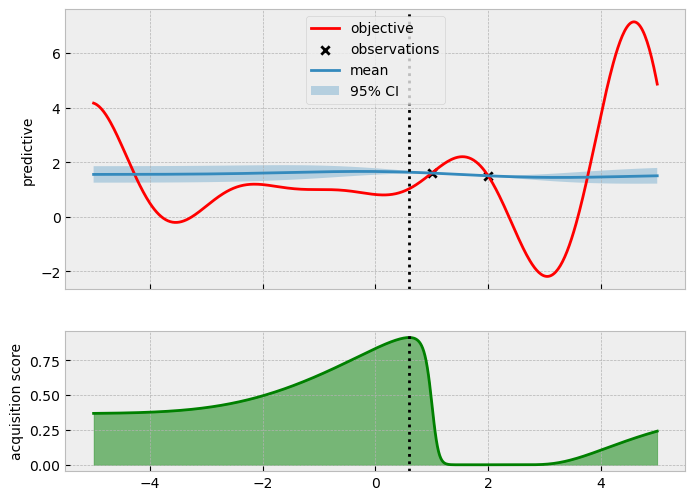

iteration 1
incumbent tensor([1.]) tensor(1.6054)


  0%|          | 0/500 [00:00<?, ?it/s]

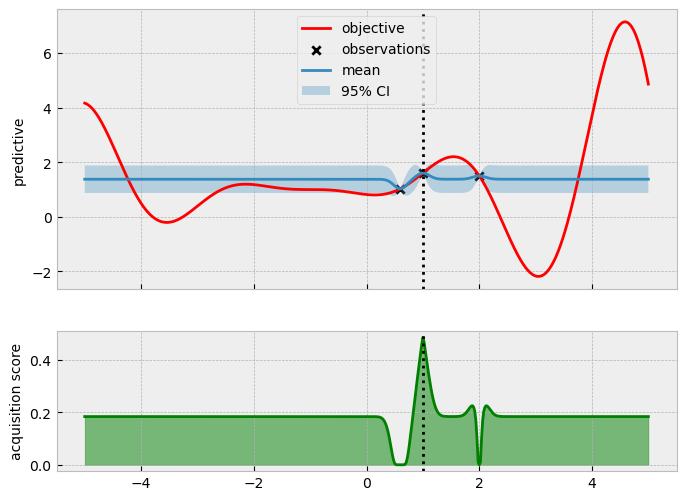

iteration 2
incumbent tensor([1.0036]) tensor(1.6114)


  0%|          | 0/500 [00:00<?, ?it/s]

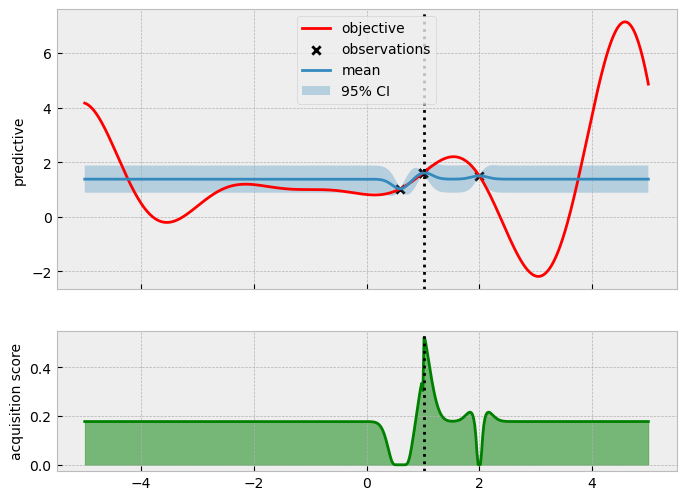

iteration 3
incumbent tensor([1.0239]) tensor(1.6449)


  0%|          | 0/500 [00:00<?, ?it/s]

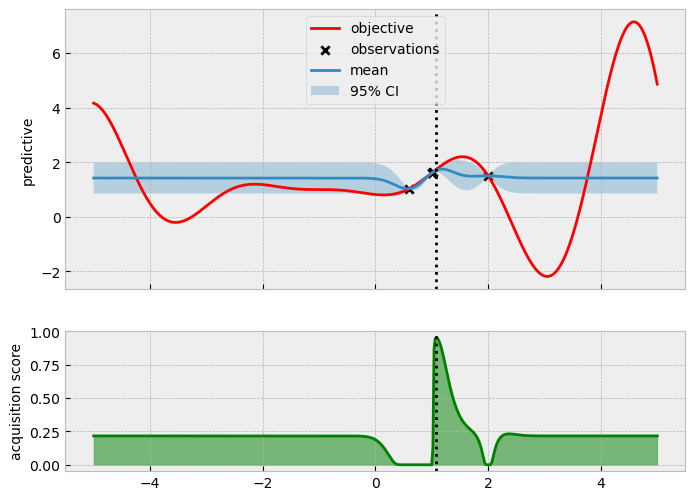

iteration 4
incumbent tensor([1.0791]) tensor(1.7351)


  0%|          | 0/500 [00:00<?, ?it/s]

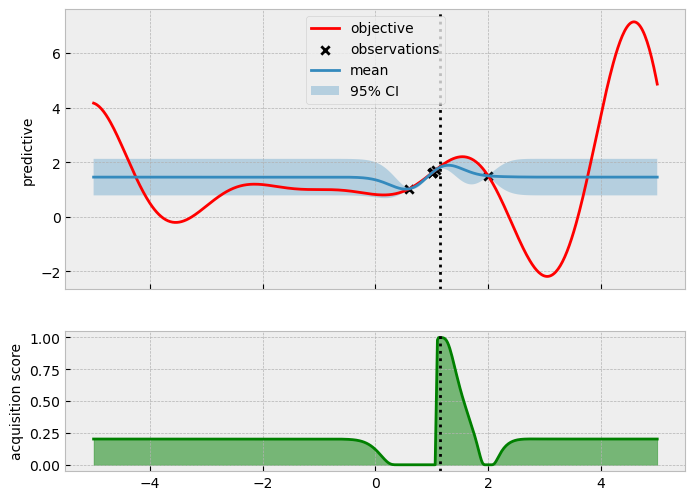

iteration 5
incumbent tensor([1.1455]) tensor(1.8400)


  0%|          | 0/500 [00:00<?, ?it/s]

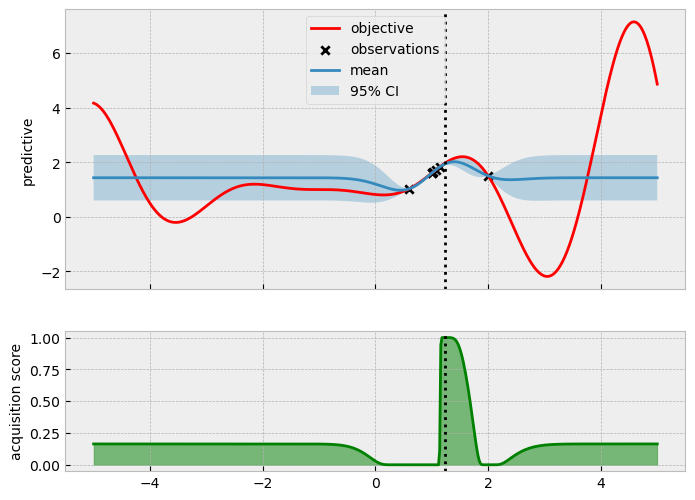

iteration 6
incumbent tensor([1.2283]) tensor(1.9608)


  0%|          | 0/500 [00:00<?, ?it/s]

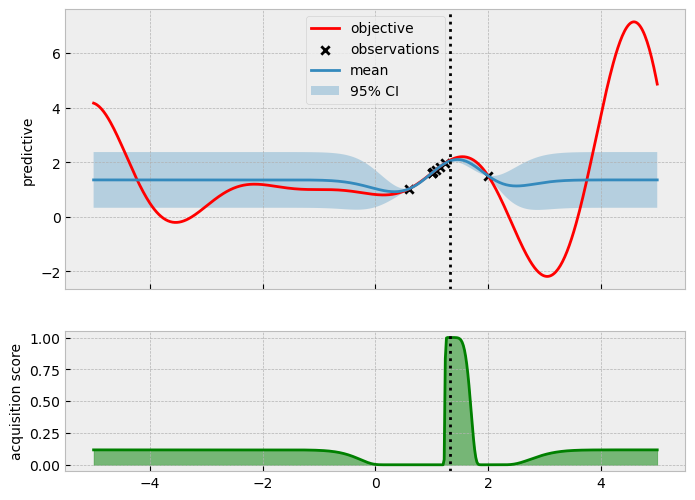

iteration 7
incumbent tensor([1.3237]) tensor(2.0776)


  0%|          | 0/500 [00:00<?, ?it/s]

/Users/quannguyen/anaconda3/envs/gp_bo_new/lib/python3.10/site-packages/botorch/optim/optimize.py:350: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


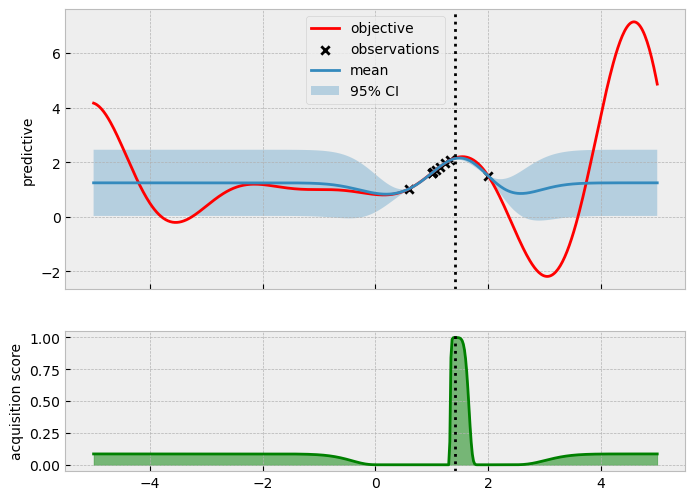

iteration 8
incumbent tensor([1.4191]) tensor(2.1611)


  0%|          | 0/500 [00:00<?, ?it/s]

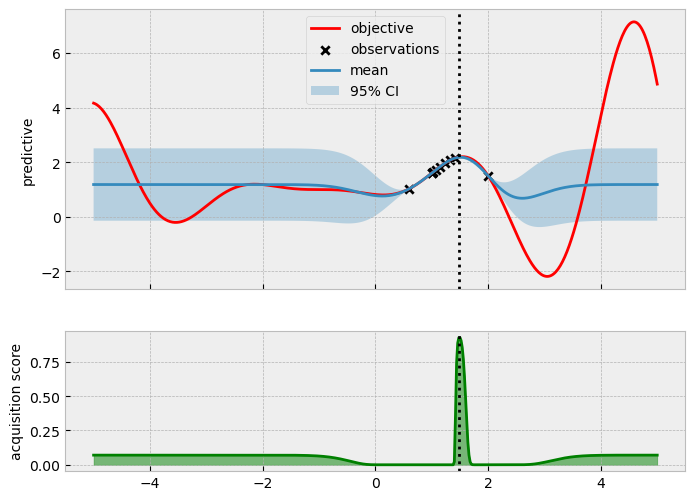

iteration 9
incumbent tensor([1.4896]) tensor(2.1958)


  0%|          | 0/500 [00:00<?, ?it/s]

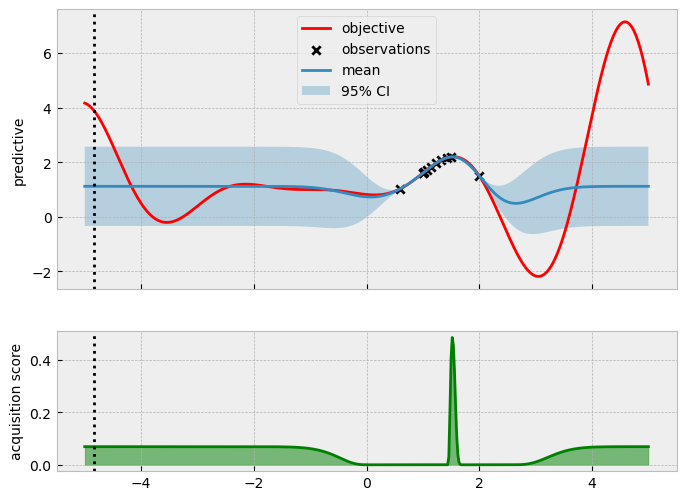

In [6]:
num_queries = 10

for i in range(num_queries):
    print("iteration", i)
    print("incumbent", train_x[train_y.argmax()], train_y.max())

    model, likelihood = fit_gp_model(train_x, train_y)

    policy = botorch.acquisition.analytic.ProbabilityOfImprovement(
        model, best_f=train_y.max()
    )
    
    
    next_x, acq_val = botorch.optim.optimize_acqf(
        policy,
        bounds=torch.tensor([[-bound * 1.0], [bound * 1.0]]),
        q=1,
        num_restarts=20,
        raw_samples=50,
    )

    visualize_gp_belief_and_policy(model, likelihood, policy, next_x=next_x)

    next_y = forrester_1d(next_x)

    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])

## 2.3 Optimizing the expected value of improvement

iteration 0
incumbent tensor([1.]) tensor(1.6054)


  0%|          | 0/500 [00:00<?, ?it/s]

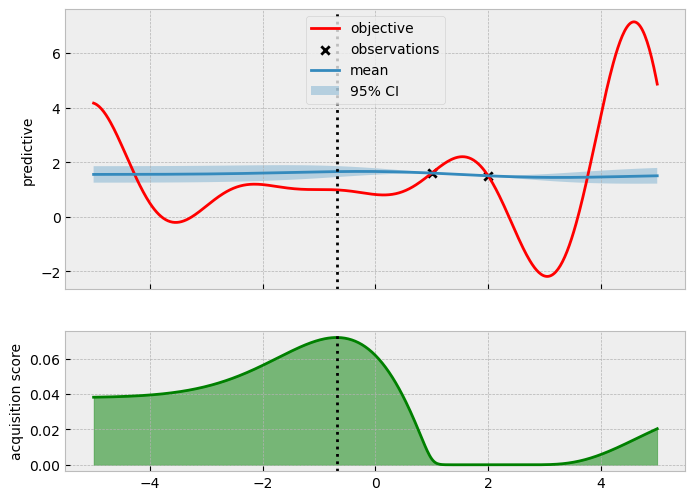

tensor([[ 1.0000],
        [ 2.0000],
        [-0.6873]])
tensor([1.6054, 1.5029, 0.9886])
iteration 1
incumbent tensor([1.]) tensor(1.6054)


  0%|          | 0/500 [00:00<?, ?it/s]

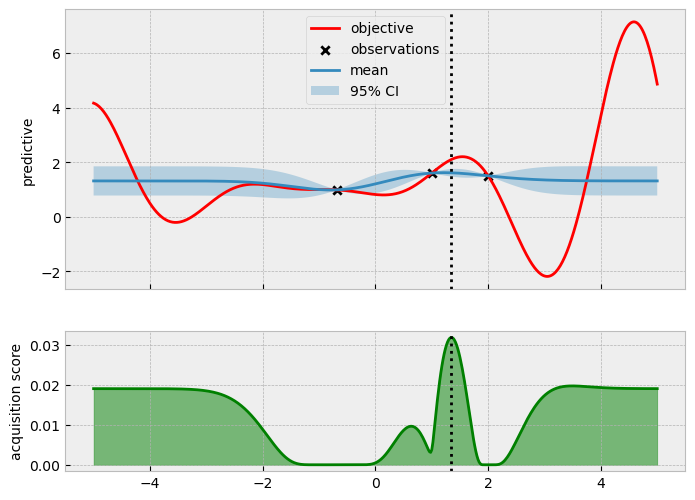

tensor([[ 1.0000],
        [ 2.0000],
        [-0.6873],
        [ 1.3486]])
tensor([1.6054, 1.5029, 0.9886, 2.1031])
iteration 2
incumbent tensor([1.3486]) tensor(2.1031)


  0%|          | 0/500 [00:00<?, ?it/s]

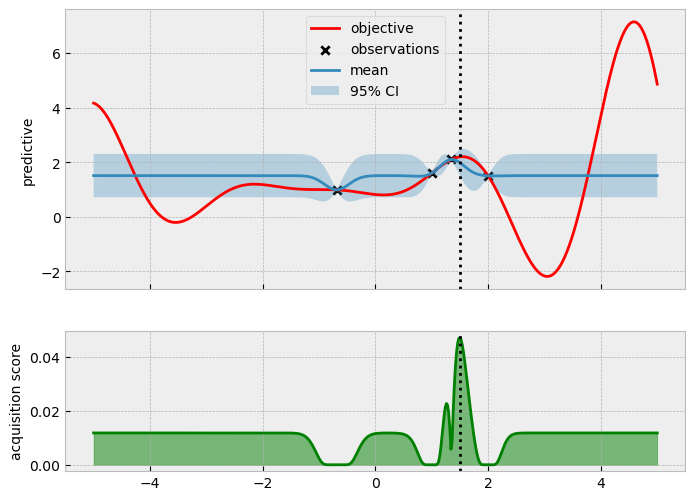

tensor([[ 1.0000],
        [ 2.0000],
        [-0.6873],
        [ 1.3486],
        [ 1.4948]])
tensor([1.6054, 1.5029, 0.9886, 2.1031, 2.1973])
iteration 3
incumbent tensor([1.4948]) tensor(2.1973)


  0%|          | 0/500 [00:00<?, ?it/s]

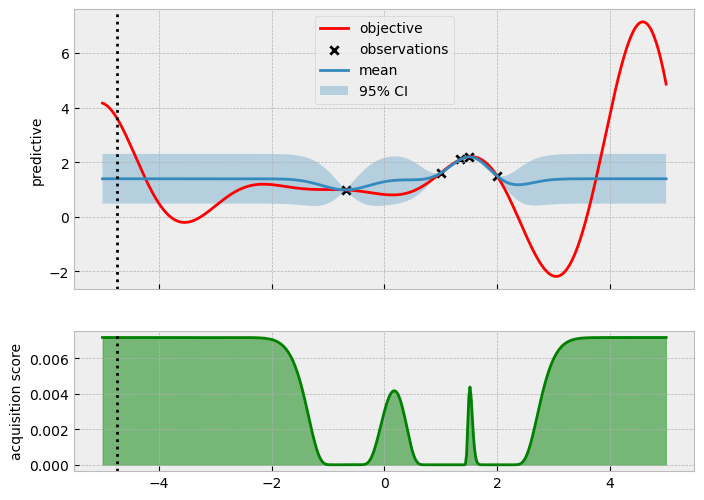

tensor([[ 1.0000],
        [ 2.0000],
        [-0.6873],
        [ 1.3486],
        [ 1.4948],
        [-4.7475]])
tensor([1.6054, 1.5029, 0.9886, 2.1031, 2.1973, 3.6296])
iteration 4
incumbent tensor([-4.7475]) tensor(3.6296)


  0%|          | 0/500 [00:00<?, ?it/s]

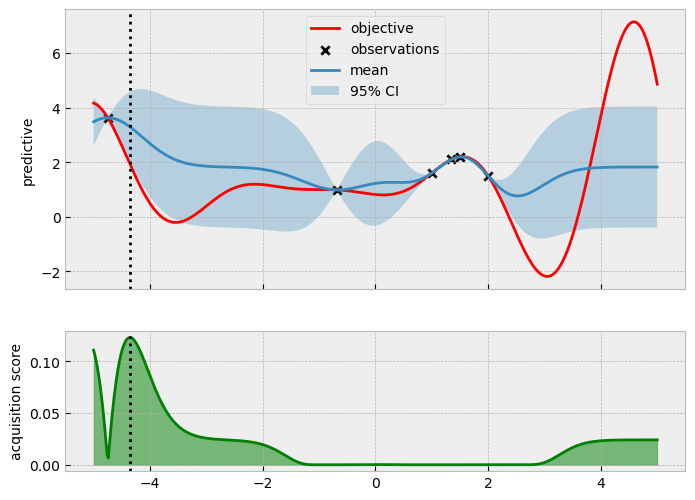

tensor([[ 1.0000],
        [ 2.0000],
        [-0.6873],
        [ 1.3486],
        [ 1.4948],
        [-4.7475],
        [-4.3553]])
tensor([1.6054, 1.5029, 0.9886, 2.1031, 2.1973, 3.6296, 1.9332])
iteration 5
incumbent tensor([-4.7475]) tensor(3.6296)


  0%|          | 0/500 [00:00<?, ?it/s]

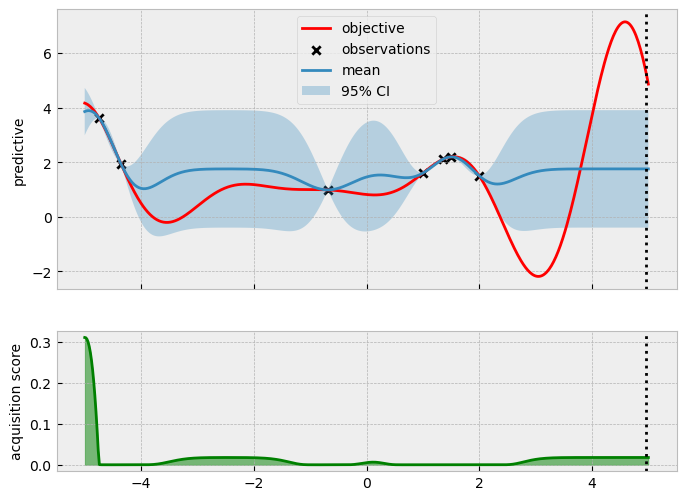

tensor([[ 1.0000],
        [ 2.0000],
        [-0.6873],
        [ 1.3486],
        [ 1.4948],
        [-4.7475],
        [-4.3553],
        [ 4.9572]])
tensor([1.6054, 1.5029, 0.9886, 2.1031, 2.1973, 3.6296, 1.9332, 5.3068])
iteration 6
incumbent tensor([4.9572]) tensor(5.3068)


  0%|          | 0/500 [00:00<?, ?it/s]

/Users/quannguyen/anaconda3/envs/gp_bo_new/lib/python3.10/site-packages/botorch/optim/optimize.py:350: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


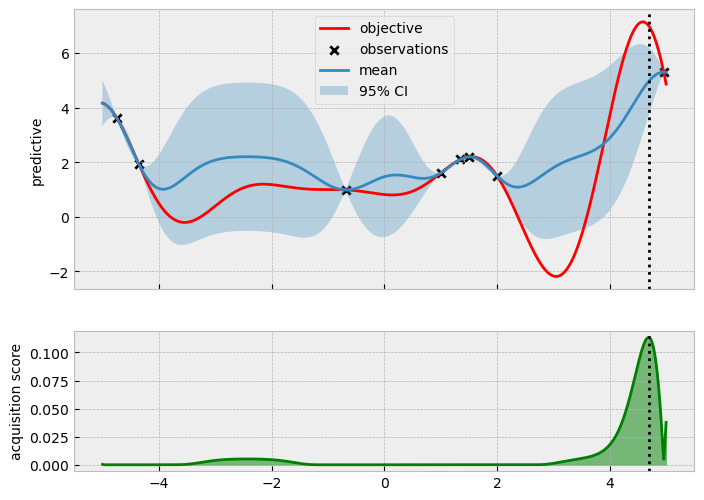

tensor([[ 1.0000],
        [ 2.0000],
        [-0.6873],
        [ 1.3486],
        [ 1.4948],
        [-4.7475],
        [-4.3553],
        [ 4.9572],
        [ 4.6888]])
tensor([1.6054, 1.5029, 0.9886, 2.1031, 2.1973, 3.6296, 1.9332, 5.3068, 7.0060])
iteration 7
incumbent tensor([4.6888]) tensor(7.0060)


  0%|          | 0/500 [00:00<?, ?it/s]

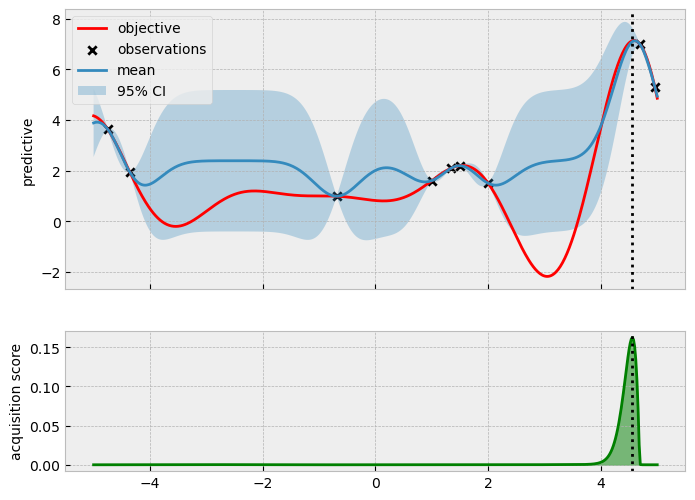

tensor([[ 1.0000],
        [ 2.0000],
        [-0.6873],
        [ 1.3486],
        [ 1.4948],
        [-4.7475],
        [-4.3553],
        [ 4.9572],
        [ 4.6888],
        [ 4.5586]])
tensor([1.6054, 1.5029, 0.9886, 2.1031, 2.1973, 3.6296, 1.9332, 5.3068, 7.0060,
        7.1340])
iteration 8
incumbent tensor([4.5586]) tensor(7.1340)


  0%|          | 0/500 [00:00<?, ?it/s]

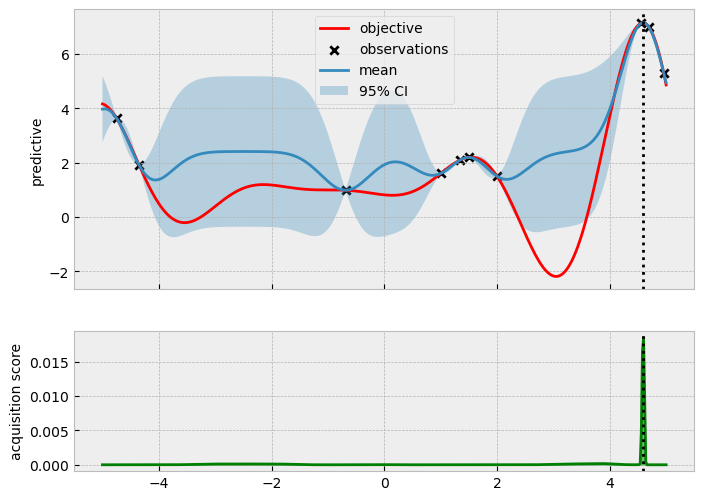

tensor([[ 1.0000],
        [ 2.0000],
        [-0.6873],
        [ 1.3486],
        [ 1.4948],
        [-4.7475],
        [-4.3553],
        [ 4.9572],
        [ 4.6888],
        [ 4.5586],
        [ 4.5934]])
tensor([1.6054, 1.5029, 0.9886, 2.1031, 2.1973, 3.6296, 1.9332, 5.3068, 7.0060,
        7.1340, 7.1432])
iteration 9
incumbent tensor([4.5934]) tensor(7.1432)


  0%|          | 0/500 [00:00<?, ?it/s]

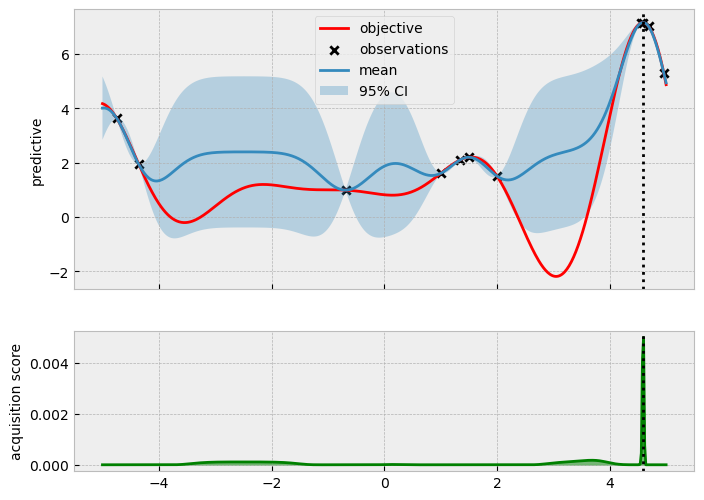

tensor([[ 1.0000],
        [ 2.0000],
        [-0.6873],
        [ 1.3486],
        [ 1.4948],
        [-4.7475],
        [-4.3553],
        [ 4.9572],
        [ 4.6888],
        [ 4.5586],
        [ 4.5934],
        [ 4.5922]])
tensor([1.6054, 1.5029, 0.9886, 2.1031, 2.1973, 3.6296, 1.9332, 5.3068, 7.0060,
        7.1340, 7.1432, 7.1434])


In [6]:
num_queries = 10

for i in range(num_queries):
    print("iteration", i)
    print("incumbent", train_x[train_y.argmax()], train_y.max())

    model, likelihood = fit_gp_model(train_x, train_y)

    policy = botorch.acquisition.analytic.ExpectedImprovement(
        model, best_f=train_y.max()
    )

    next_x, acq_val = botorch.optim.optimize_acqf(
        policy,
        bounds=torch.tensor([[-bound * 1.0], [bound * 1.0]]),
        q=1,
        num_restarts=20,
        raw_samples=50,
    )

    visualize_gp_belief_and_policy(model, likelihood, policy, next_x=next_x)

    next_y = forrester_1d(next_x)

    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])

    print(train_x)
    print(train_y)